In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext wurlitzer
%matplotlib ipympl

import numpy as np
import xobjects as xo

import xcoll as xc
from xcoll.scattering_routines.geometry.trajectories import get_max_crossings

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def check_drift(shape, plot_object=False, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5)):
    to_remove = []
    s_val = np.linspace(*xlim, 200)
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    if plot_object:
        shape.plot(axes=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    n_hit = np.zeros(1, dtype=np.int8)
    s = np.zeros(get_max_crossings(shape, "drift"), dtype=np.float64)
    # s = np.zeros(8, dtype=np.float64)

    def update_plot(s0, x0, part_theta):
        # Clean the previous trajectory and points
        while to_remove:
            last_point = to_remove.pop()  # Get the last added point
            last_point.remove()
        m = np.tan(np.radians(part_theta))
        # Draw drift trajectory and point
        spread = 10 # degrees
        line, = ax.plot(s_val, m*(s_val - s0) + x0, c='k')
        to_remove.append(line)
        scatter = ax.scatter(s0, x0, c='r', s=20)
        to_remove.append(scatter)
        m1 = np.tan(np.radians(part_theta+spread))
        m2 = np.tan(np.radians(part_theta-spread))
        line = ax.fill_between(s_val, m1*(s_val - s0) + x0, m2*(s_val - s0) + x0, alpha=0.2)
        to_remove.append(line)
        # Create hits for different slopes (small cone around the trajectory)
        hits_s = []
        hits_x = []
        for sp in np.linspace(-spread, spread, 100):
            n_hit[0] = 0
            m = np.tan(np.radians(part_theta + sp))
            if isinstance(shape, xc.Shape2DV):
                shape.crossing_drift(n_hit=n_hit, s=s, s0=s0, x0=x0, xm=m, y0=0, ym=0)
            else:
                shape.crossing_drift(n_hit=n_hit, s=s, s0=s0, x0=x0, xm=m)
            hits_s += list(s[:n_hit[0]])
            hits_x += list(x0 + m*(s[:n_hit[0]] - s0))
        # for i in range(n_hit[0]):
        scatter = ax.scatter(hits_s, hits_x, c='g', s=5)
        # to_remove.append(scatter)
        fig.canvas.draw()  # Redraw the canvas to show the new point


    def onclick(event):
        s0, x0 = event.xdata, event.ydata
        if s0 is not None and x0 is not None:  # Ensure the click is inside the plot
            update_plot(s0, x0, part_theta_slider.value)


    fig.canvas.mpl_connect('button_press_event', onclick)
    part_theta_slider = widgets.IntSlider(min=-89, max=89, step=1, value=0)

    @interact(part_theta=part_theta_slider)
    def check_linesegments(part_theta):
        if to_remove:
            scatter = to_remove[1]  # The second point is the clicked scatter point
            s0, x0 = scatter.get_offsets()[0, 0], scatter.get_offsets()[0, 1]

            # Update the plot with the new slope based on the slider
            update_plot(s0, x0, part_theta)

In [22]:
shape1 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)])
shape2 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                     xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                     xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                     xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                     xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                     xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                     xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
shape3 = xc.Shape2DV([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                      xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                      xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                      xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                      xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                      xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                      xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)],
                    vlimit=[-0.1, 0.1])

In [15]:
self = shape2
for shape, is_open in zip(self._shapes, self.is_open()):
    coords = []
    if is_open:
        for seg1, seg2 in zip(shape[:-1], shape[1:]):
            coords.append(self[seg1].connection_to(self[seg2]))
    else:
        for seg1, seg2 in zip(shape, [*shape[1:], shape[0]]):
            coords.append(self[seg1].connection_to(self[seg2]))
        coords.insert(0, coords[-1])
    print(coords)

[[(0.0, 0.0)], [(0.2, 1.0)], [(0.6464466094067263, 0.8535533905932737)], [(1.0, 0.0)], [(0.0, 0.0)]]
[[(2.0, 1.0)], [(3.0, 0.0)]]


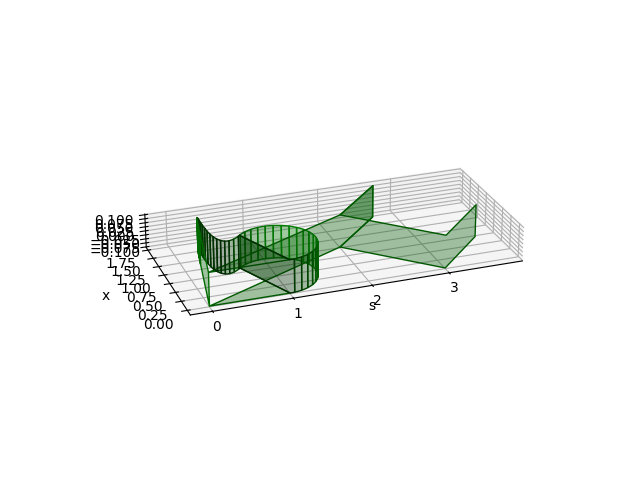

In [51]:
num_points = 100
self = shape2
c = 'green'

s = []
x = []
ymax = 0.2
ymin = -0.2
for seg in self.segments:
    if seg.__class__ == xc.CircularSegment:
        t = np.linspace(seg.t1, seg.t2, num_points)
    elif seg.__class__ == xc.BezierSegment:
        t = np.linspace(0, 1, num_points)
    else:
        t = [0, 1]
    this_s, this_x = seg.evaluate(t)
    s += this_s
    x += this_x
shape_B = np.array([s, x, [-0.1 for _ in range(len(s))]]).T
shape_T = np.array([s, x, [0.1 for _ in range(len(s))]]).T
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=25, azim=-110)
ax.set_box_aspect([max(s)-min(s), max(x)-min(x),ymax-ymin])
ax.plot_surface(*np.array([shape_B, shape_T]).T, alpha=0.35, facecolors=[c for _ in range(len(s))])
ax.set_xlabel('s')
ax.set_ylabel('x')
plt.show()

In [6]:
obj_L_B

array([[ 0. ,  0. , -0.1],
       [ 1. ,  0.2, -0.1],
       [ 1. ,  1. , -0.1],
       [ 0. ,  0.8, -0.1],
       [ 0. ,  0. , -0.1]])

In [9]:
np.array([obj_L_B, obj_L_T]).T

array([[[ 0. ,  0. ],
        [ 1. ,  1. ],
        [ 1. ,  1. ],
        [ 0. ,  0. ],
        [ 0. ,  0. ]],

       [[ 0. ,  0. ],
        [ 0.2,  0.2],
        [ 1. ,  1. ],
        [ 0.8,  0.8],
        [ 0. ,  0. ]],

       [[-0.1,  0.1],
        [-0.1,  0.1],
        [-0.1,  0.1],
        [-0.1,  0.1],
        [-0.1,  0.1]]])

In [ ]:

        for seg in self.segments:
            if seg.__class__ == CircularSegment:
                t = np.linspace(-np.pi, np.pi, 1000)
            elif seg.__class__ == HalfOpenLineSegment:
                t = np.linspace(0, 0.6, 1000)
            else:
                t = np.linspace(0, 1, 1000)
            s, x = seg.evaluate(t)
            axes.plot(s, x, c='tab:blue')
            if seg.__class__ == HalfOpenLineSegment:
                t = np.linspace(0.6, 1, 1000)
                s, x = seg.evaluate(t)
                axes.plot(s, x, c='tab:blue', ls='--')
        axes.set_aspect('equal')
        return axes.figure, axes

In [ ]:
shape1 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)])

check_drift(shape1, plot_object=False)

In [ ]:
shape2 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                     xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                     xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                     xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                     xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                     xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                     xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
check_drift(shape2, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=True)

In [ ]:
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=np.pi/2,  t2=-np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=3*np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=2*np.pi)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=-np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=0)
seg = xc.CircularSegment(R=1, s=0., x=0., t1=3*np.pi/2,t2=0)

check_drift(xc.Shape2D([seg]), plot_object=True, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

In [ ]:
shape3 = xc.Shape2DV([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                      xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                      xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                      xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                      xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                      xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                      xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)],
                    vlimit=[-0.1, 0.1])
check_drift(shape3, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=True)